In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self.probs = np.random.uniform(size=n_actions)
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        self.n_actions = n_actions
    
    def step(self, action):
        if np.random.rand() < self.probs[action]:
            return 1
        else:
            return 0

np.random.seed(888)
K = 10 
bandit_10_arm = BernoulliBandit(n_actions=K)
print(f"Best arm: {bandit_10_arm.best_idx}, with probability {bandit_10_arm.best_prob}")


Best arm: 6, with probability 0.9250074344293425


In [3]:
class Solver:
    def __init__(self, bandit):
        self.bandit = bandit 
        self.counts = np.zeros(self.bandit.n_actions) # record total number of each bandit been pulled 
        self.regret = 0 # current cumulative regret 
        self.actions = [] # record of all actions taken 
        self.regrets = [] # record of all regrets for each action taken 
    
    def update_regret(self, action):
        self.regret += self.bandit.best_prob - self.bandit.probs[action]
        self.regrets.append(self.regret)
    
    def run_one_step(self):
        raise NotImplementedError()

    def run(self, n_steps):
        for _ in range(n_steps):
            action = self.run_one_step()
            self.counts[action] += 1
            self.actions.append(action)
            self.update_regret(action)

## $\epsilon$-greedy

In [4]:
class EpsilonGreedy(Solver):
    ''' Slove multi-armed bandit problem using epsilon-greedy algorithm '''
    def __init__(self, bandit, epsilon = 0.01, init_prob = 1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon 
        self.estimates = np.array([init_prob] * self.bandit.n_actions) # initial guess of each bandit's reward

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.bandit.n_actions)
        else:
            action = np.argmax(self.estimates)
        r = self.bandit.step(action)
        self.estimates[action] += 1.0 / (self.counts[action] + 1) * (r - self.estimates[action]) # update reward estimation based on true reward 
        return action 


Total regret: 17.233971914297083


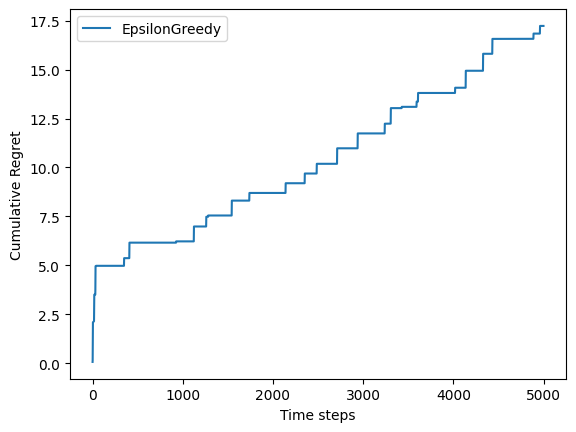

In [7]:
def plot_results(solvers, solver_names):
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative Regret')
    #plt.title('%d-amred bandit problem' % solver[0].bandit.n_actions)
    plt.legend()
    plt.show()

np.random.seed(888)
EpsilonGreedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
EpsilonGreedy_solver.run(5000)
print(f"Total regret: {EpsilonGreedy_solver.regret}")
plot_results([EpsilonGreedy_solver], ['EpsilonGreedy'])

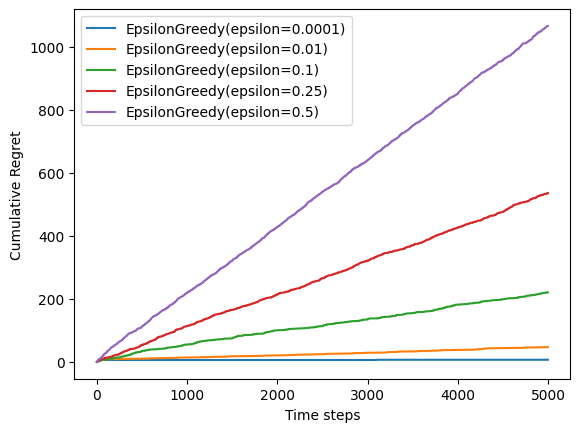

In [8]:
epsilon = [1e-4,0.01,0.1,0.25,0.5]
epsilon_greedy_solvers = [
    EpsilonGreedy(bandit_10_arm, epsilon=eps) for eps in epsilon
]

epsilon_greedy_solver_names = [f'EpsilonGreedy(epsilon={eps})' for eps in epsilon]

for solver in epsilon_greedy_solvers:
    solver.run(5000)

plot_results(epsilon_greedy_solvers, epsilon_greedy_solver_names)

## Decay $\epsilon$-greedy algortihm 

In [11]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon will decay over time"""
    def __init__(self, bandit, init_prob = 1.0):
        super(DecayingEpsilonGreedy,self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.n_actions)
        self.total_counts = 0 #epsilon = 1/(total_counts + 1)

    def run_one_step(self):
        self.total_counts += 1
        if np.random.random() < 1/self.total_counts:
            action = np.random.randint(self.bandit.n_actions)
        else: 
            action = np.argmax(self.estimates)
            r = self.bandit.step(action)
            self.estimates[action] += 1.0 / (self.counts[action] + 1) * (r - self.estimates[action])

        return action 

Total regret: 8.539208444161323


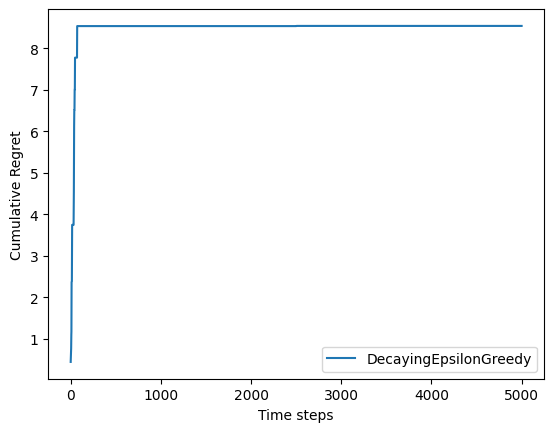

In [12]:
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print(f"Total regret: {decaying_epsilon_greedy_solver.regret}")
plot_results([decaying_epsilon_greedy_solver], ['DecayingEpsilonGreedy'])

## Upper confidence bound UCB

In [15]:
class UCB(Solver):
    """ upper confidence bound algorithm """
    def __init__(self,bandit, coef, init_prob = 1.0):
        super(UCB,self).__init__(bandit)
        self.total_counts = 0 
        self.estimates = np.array([init_prob] * self.bandit.n_actions)
        self.coef = coef
    
    def run_one_step(self):
        self.total_counts += 1
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_counts) / (2 * self.counts + 1)) #p = 1/t
        action = np.argmax(ucb)
        r = self.bandit.step(action)
        self.estimates[action] += 1.0 / (self.counts[action] + 1) * (r - self.estimates[action])
        return action


Total regret: 96.85163588124517


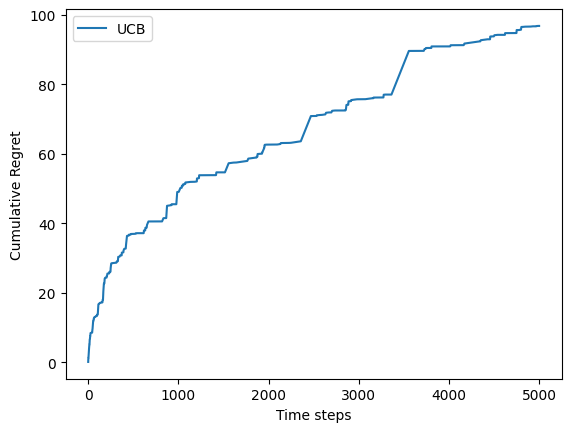

In [16]:
coef = 1 
ucb_solver = UCB(bandit_10_arm, coef)
ucb_solver.run(5000)
print(f"Total regret: {ucb_solver.regret}")
plot_results([ucb_solver], ['UCB'])

## Thompson Sampling 

In [17]:
class ThompsonSampling(Solver):
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.n_actions) # numer of success from each bandit 
        self._b = np.ones(self.bandit.n_actions) # numer of failure from each bandit

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)
        action = np.argmax(samples)
        r = self.bandit.step(action)

        self._a[action] += r
        self._b[action] += 1 - r

        return action

Total regret: 38.944638738018085


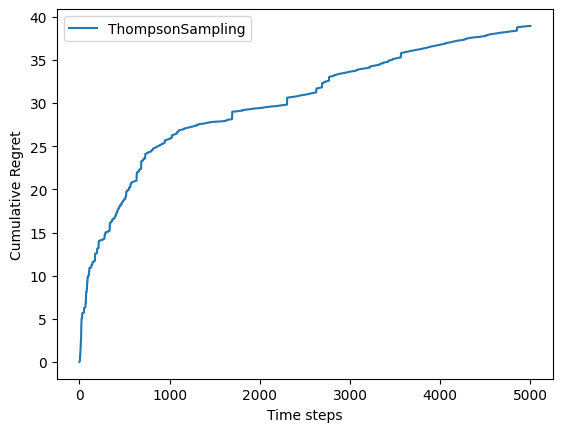

In [18]:
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print(f"Total regret: {thompson_sampling_solver.regret}")
plot_results([thompson_sampling_solver], ['ThompsonSampling'])